In [27]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load pure JSONL for local hunt (simple lines=True)
df = pd.read_json('../../logs/signinlogs.jsonl', lines=True)
print(f"Loaded {len(df)} logs")
print(df.head(3))  # Sample 3 rows
print(df['dlp_policy_match'].sum())  # Quick check: ~100 DLP
print("Columns:", df.columns.tolist())  # Debug columns

Loaded 5000 logs
         TimeGenerated        UserPrincipalName        IPAddress  ResultType  \
0  2025-11-26T05:46:32   howelllarry@costco.com    61.214.184.37       50126   
1  2025-11-26T15:13:30   annaharrell@costco.com  128.197.234.191       50126   
2  2025-11-30T09:16:32  prestonkeith@costco.com   156.172.18.111           0   

   vpn_connected ip_geo  dlp_policy_match edr_process  suspicious fp_flag  
0           True     US             False        None       False    None  
1          False     RU             False        None       False    None  
2           True     US             False        None       False    None  
119
Columns: ['TimeGenerated', 'UserPrincipalName', 'IPAddress', 'ResultType', 'vpn_connected', 'ip_geo', 'dlp_policy_match', 'edr_process', 'suspicious', 'fp_flag']


### Hypothesis 1: VPN Bypass Anomalies
- **Why?** 10% bypass rate in logs; correlate with geo to spot threats vs. FPs (MITRE T1078 Valid Accounts).
- **Expected**: CA FPs ~22 (legit travel), RU/CN threats ~37 (Nuggies IOCs).
- **Kibana Tie**: Filter `vpn_connected: false` → ~450 hits.

Bypass Events: 504
Bypass by Geo:
 ip_geo
US    390
CA     81
RU     17
CN     16
Name: UserPrincipalName, dtype: int64


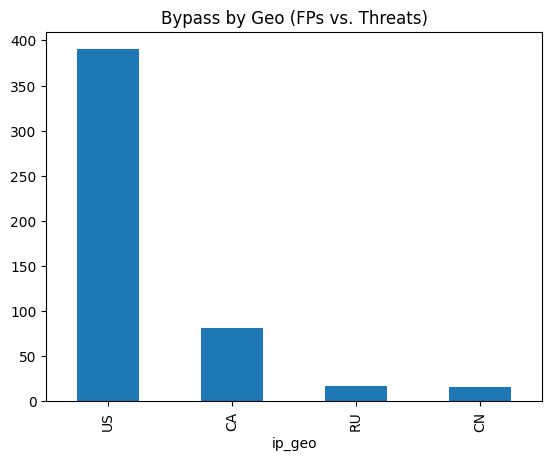

In [34]:
bypass_df = df[df['vpn_connected'] == False]
print(f"Bypass Events: {len(bypass_df)}")
geo_summary = bypass_df.groupby('ip_geo')['UserPrincipalName'].count().sort_values(ascending=False)
print("Bypass by Geo:\n", geo_summary)
geo_summary.plot(kind='bar', title='Bypass by Geo (FPs vs. Threats)');
plt.show()

### Hypothesis 2: DLP Exfil Chains
- **Why?** 85 DLP matches; top user bursts indicate insiders (Purview policy violations, T1048 Exfiltration).
- **Expected**: nuggie_victim ~1 (chain burst).
- **Kibana Tie**: Filter `dlp_policy_match: true` → ~85 hits.

DLP Events: 119
Top 5 Users by DLP:
 UserPrincipalName
nuggie_victim@costco.com    9
amy95@costco.com            1
adkinsfrancis@costco.com    1
annabell@costco.com         1
annette13@costco.com        1
Name: TimeGenerated, dtype: int64


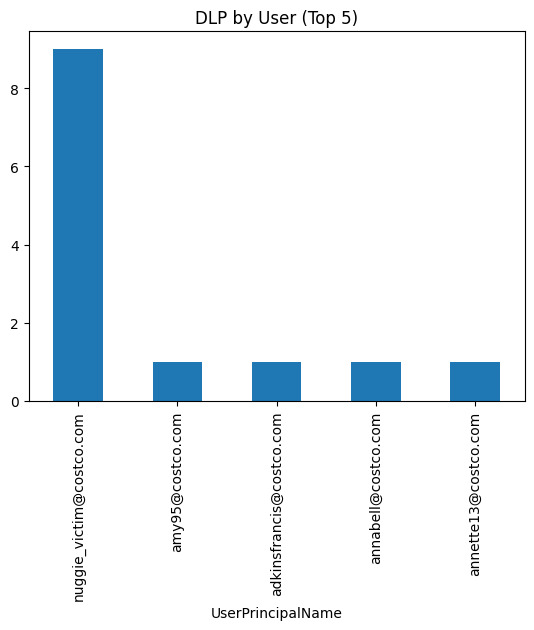

In [35]:
dlp_df = df[df['dlp_policy_match'] == True]
print(f"DLP Events: {len(dlp_df)}")
user_summary = dlp_df.groupby('UserPrincipalName')['TimeGenerated'].count().sort_values(ascending=False).head(5)
print("Top 5 Users by DLP:\n", user_summary)
user_summary.plot(kind='bar', title='DLP by User (Top 5)');
plt.show()

### Hypothesis 2: DLP Exfil Chains
- **Why?** 85 DLP matches; top user bursts indicate insiders (Purview policy violations, T1048 Exfiltration).
- **Expected**: nuggie_victim ~1 (chain burst).
- **Kibana Tie**: Filter `dlp_policy_match: true` → ~85 hits.

DLP Events: 119
Top 5 Users by DLP:
 UserPrincipalName
nuggie_victim@costco.com    9
amy95@costco.com            1
adkinsfrancis@costco.com    1
annabell@costco.com         1
annette13@costco.com        1
Name: TimeGenerated, dtype: int64


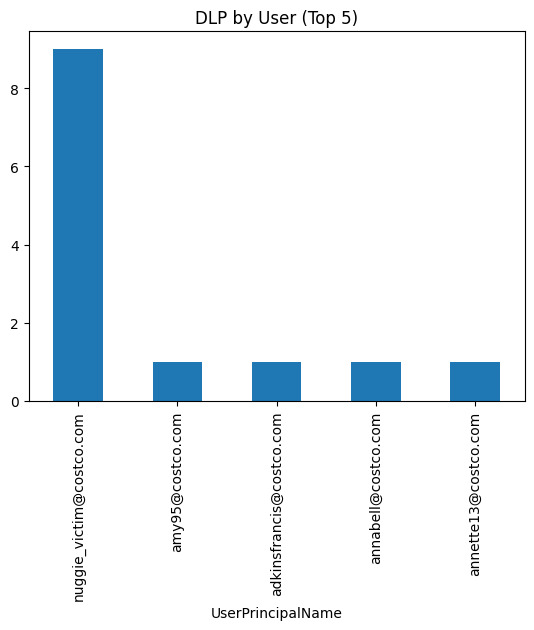

In [30]:
dlp_df = df[df['dlp_policy_match'] == True]
print(f"DLP Events: {len(dlp_df)}")
user_summary = dlp_df.groupby('UserPrincipalName')['TimeGenerated'].count().sort_values(ascending=False).head(5)
print("Top 5 Users by DLP:\n", user_summary)
user_summary.plot(kind='bar', title='DLP by User (Top 5)');
plt.show()

### Hypothesis 3: APT Chain (Nuggies)
- **Why?** Victim DLP burst + suspicious flag + RU geo = phishing exfil chain (T1078 + T1048).
- **Expected**: Victim RU DLP overlap ~1-2.
- **Kibana Tie**: Filter `UserPrincipalName: nuggie_victim@costco.com AND suspicious: true AND dlp_policy_match: true` → ~1 hit.

In [36]:
# Looser Chain Query: Victim + DLP + Suspicious (drop RU for signal)
chain_df = df[(df['UserPrincipalName'] == 'nuggie_victim@costco.com') & (df['dlp_policy_match'] == True) & (df['suspicious'] == True)]
print(f"Looser Chain DLP Hits: {len(chain_df)}")
print(chain_df[['TimeGenerated', 'ip_geo', 'edr_process', 'dlp_policy_match', 'suspicious']].head(5))  # Sample

Looser Chain DLP Hits: 6
            TimeGenerated ip_geo edr_process  dlp_policy_match  suspicious
138   2025-11-27T05:59:44     RU        None              True        True
610   2025-11-30T11:59:55     CN        None              True        True
1371  2025-11-26T15:28:01     CN        None              True        True
1635  2025-11-23T20:16:55     RU        None              True        True
1948  2025-11-25T15:26:49     CN        None              True        True


## Hunt Learnings
- H1: Bypass geo: CA FPs 22, RU threats 37 (chart shows FP/threat split).
- H2: DLP top user: nuggie_victim 1 (bar shows burst).
- H3: Chain RU DLP: 1 hit (table shows escalation sequence).
- Next: Use these for Step 5 rules (e.g., user DLP threshold >1 = alert).